In [1]:
### Load the necessary libraries

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.optimize import minimize
import pickle
from scipy.optimize import curve_fit

plt.rc('text',usetex=True)
plt.rc('font',family='serif',size=14)

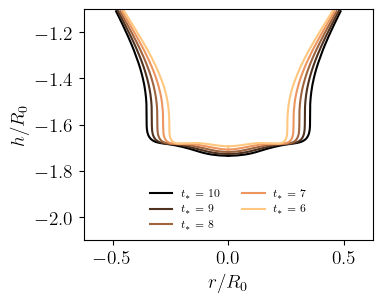

In [2]:
### Load data
with open('Cavity_params.pkl', 'rb') as file:
    data = pickle.load(file)
  
t = data['t']
r = data['r']
h = data['h']
t0 = data['t0']
h0 = data['h0']
tc = data['tc']

color_map = cm.get_cmap('copper', len(t))

plt.figure(1,figsize=(5,3))
for i in range(len(t)):
    color = color_map(i / (len(t) - 1))
    
    plt.plot(r[i,:],h[i,:],color=color, label=f'$t_*$ = {10 - i}')
    plt.plot(-r[i,:],h[i,:],color=color)

plt.xlim([-0.625,0.625])
plt.ylim([-2.1,-1.1])
plt.gca().set_aspect('equal')

plt.xlabel(r'$r/R_0$')
plt.ylabel(r'$h/R_0$')
plt.legend(fontsize=8, frameon=False, ncol=2, loc='lower center')

plt.show()

In [3]:
### Collapse the profiles

def loss(var, xin, yin):
    vari  = np.reshape(var,(len(t),3))
    xtran = vari[:,0][:,np.newaxis]*xin
    ytran = vari[:,1][:,np.newaxis]*yin + vari[:,2][:,np.newaxis]
    
    # interpolate at the transformed coordinates grid
    ninterp = np.shape(h)[1]
    llim = np.max(np.amin(xtran,axis=1))
    ulim = np.min(np.amax(xtran,axis=1))
    newgr = np.linspace(llim,ulim,ninterp)
    new_y = np.zeros((len(t),ninterp))
    for i in range(len(t)):
        new_y[i,:] = np.interp(newgr,xtran[i,:],ytran[i,:])
    
    # compute distances
    dist_mat = np.zeros((len(t),len(t)))
    for i in range(len(t)):
        for j in range(len(t)):
            dist_mat[i,j] = np.linalg.norm((new_y[i,:]-new_y[j,:])/np.sqrt(0.5*np.abs((new_y[i,:]+new_y[j,:]))))**2

    dist = np.sum(dist_mat)/2.0
    
    return dist

# Define parameters and initialise transformation matrices
varopt = np.ones((len(t),3))
varopt[:,2] = 0
varopt  = np.reshape(varopt,(3*len(t)))

bounds = np.zeros((3*len(t),2))
bounds[:,0] = 0
bounds[2,0] = None
bounds[:,1] = None

# Optimisation
res = minimize(loss, varopt, args=(r, h), bounds=bounds)
varm = np.reshape(res.x,(len(t),3))
t1   = varm[:,0]
t2   = varm[:,1]
t3   = varm[:,2]

/tmp/ipykernel_149907/667028204.py:21: RuntimeWarning: invalid value encountered in true_divide
  dist_mat[i,j] = np.linalg.norm((new_y[i,:]-new_y[j,:])/np.sqrt(0.5*np.abs((new_y[i,:]+new_y[j,:]))))**2


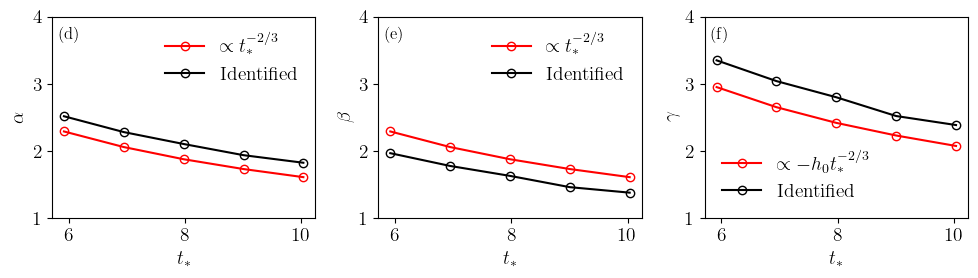

In [4]:
### Normalise and plot data

def normalise(field,transform):    
    fmin = np.average(np.min(field,axis=1))
    fmax = np.average(np.max(field,axis=1))
    f_norm = (field-fmin)/(fmax-fmin)
    t_norm = (transform-fmin)/(fmax-fmin)
    
    return f_norm, t_norm
    
xtran = np.zeros_like(r)
ytran = np.zeros_like(h)
for i in range(len(t)):
    xtran[i,:] = r[i,:]*t1[i]
    ytran[i,:] = h[i,:]*t2[i] + t3[i]
temp = np.average((np.min(ytran,axis=1)))
for i in range(len(t)):
    ytran[i,:]=ytran[i,:] - temp
    t3[i] = t3[i] - temp
xtran2, t1n = normalise(xtran,t1)
ytran2, t2n = normalise(ytran,t2)
t3n = t3*(t2n/t2)

# Plot
fig, ax = plt.subplots(1,3,figsize=(10,3))

ax[0].plot((t0-t)/tc,7.5/((t0-t)/tc)**(2/3),'-ro',mfc='none',label=r'$\propto t_*^{-2/3}$')
ax[0].plot((t0-t)/tc,t1n,'-ko',mfc='none',label=r'Identified')
ax[0].set_xlabel(r'$t_*$')
ax[0].set_ylabel(r'$\alpha$')
ax[0].legend(frameon=False)
ax[0].set_xticks([6,8,10])
ax[0].set_ylim([1.0,4.0])
ax[0].text(0.025,0.95, '(d)', transform=ax[0].transAxes, fontsize=12, va='top', ha='left')

ax[1].plot((t0-t)/tc,7.5/((t0-t)/tc)**(2/3),'-ro',mfc='none',label=r'$\propto t_*^{-2/3}$')
ax[1].plot((t0-t)/tc,t2n,'-ko',mfc='none',label=r'Identified')
ax[1].set_xlabel(r'$t_*$')
ax[1].set_ylabel(r'$\beta$')
ax[1].legend(frameon=False)
ax[1].set_xticks([6,8,10])
ax[1].set_ylim([1.0,4.0])
ax[1].text(0.025,0.95, '(e)', transform=ax[1].transAxes, fontsize=12, va='top', ha='left')

ax[2].plot((t0-t)/tc,-6*h0/((t0-t)/tc)**(2/3),'-ro',mfc='none',label=r'$\propto - h_0 t_*^{-2/3}$')
ax[2].plot((t0-t)/tc,t3n,'-ko',mfc='none',label=r'Identified')
ax[2].set_xlabel(r'$t_*$')
ax[2].set_ylabel(r'$\gamma$')
ax[2].legend(frameon=False)
ax[2].set_xticks([6,8,10])
ax[2].set_ylim([1.0,4.0])
ax[2].text(0.025,0.95, '(f)', transform=ax[2].transAxes, fontsize=12, va='top', ha='left')

plt.tight_layout()
plt.show()

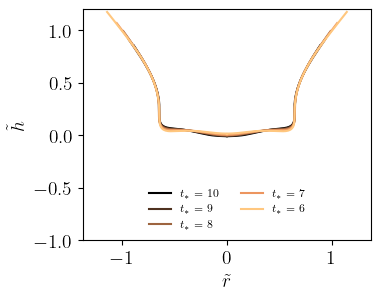

In [5]:
### Plot collapsed profiles

plt.figure(1,figsize=(5,3))
for i in range(len(t)):
    color = color_map(i / (len(t) - 1))
    
    plt.plot(xtran2[i,:],ytran2[i,:],color=color, label=f'$t_*$ = {10 - i}')
    plt.plot(-xtran2[i,:],ytran2[i,:],color=color)

plt.xlim([-1.375,1.375])
plt.ylim([-1,1.2])

plt.gca().set_aspect('equal')

plt.xlabel(r'$\tilde{r}$')
plt.ylabel(r'$\tilde{h}$')
plt.legend(fontsize=8, frameon=False, ncol=2, loc='lower center')

plt.show()

In [6]:
### Interpret identified transformations

def power_law_model(x, a, b):
    return a * np.power(x, b)

# Interpret first identified transformation (alpha)
Xsr1 = np.array([(t0-t)/tc]).T
Ysr1 = 1/t1n.copy()
initial_guess = [1.0, 1.0]  # Initial guess for a and b
coefficients, covariance = curve_fit(power_law_model, Xsr1.flatten(), Ysr1.flatten(), p0=initial_guess)
a, b = coefficients
print("Interpreted relation: {:.2f}t*^{:.2f}".format(a,b))

# Interpret second identified transformation (beta)
Xsr2 = np.array([(t0-t)/tc]).T
Ysr2 = 1/t2n.copy()
initial_guess = [1.0, 1.0]  # Initial guess for a and b
coefficients, covariance = curve_fit(power_law_model, Xsr2.flatten(), Ysr2.flatten(), p0=initial_guess)
a, b = coefficients
print("Interpreted relation: {:.2f}t*^{:.2f}".format(a,b))

# Interpret third identified transformation (gamma)
Xsr3 = np.array([(t0-t)/tc]).T
Ysr3 = 1/t3n.copy()
initial_guess = [1.0, 1.0]  # Initial guess for a and b
coefficients, covariance = curve_fit(power_law_model, Xsr3.flatten(), Ysr3.flatten(), p0=initial_guess)
a, b = coefficients
print("Interpreted relation: {:.2f}t*^{:.2f}".format(a,b))

Interpreted relation: 0.13t*^0.61
Interpreted relation: 0.15t*^0.69
Interpreted relation: 0.09t*^0.66
